# ***Presentacion***

## **Tecnicatura Universitaria en Inteligencia Artificial**

### Trabájo Práctico - Minería de Datos

#### Arboles de descicion y aprendizaje supervizado

---

**equipo**:
- Revello Simon
- Giampaoli Fabio

**Fecha**: 10/11/2023

---

## ***Objetivo***



El objetivo de este trabajo practico es integrar los conocimientos adquiridos en las unidades 4 y 5
en dos problemas reales asociados uno al comportamiento financiero de 1000 empresas y otro a
un juego de cartas,

# ***Entorno***

## Librerias

In [140]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ipywidgets import widgets, interact
from IPython.display import clear_output

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split

## Datasets

In [77]:
cartas = pd.read_csv('PokemonDB.csv')
companies = pd.read_csv('1000_Companies.csv')

# ***Ejercicios***

## **Primer ejercicio**

---

Descargar el conjunto de datos, 1000_Companies.csv1, para realizar el trabajo práctico.
Analizar los atributos del conjunto de datos (distribuciones, valores, outliers, tipos de
datos, etc.) y elegir un método de estandarización

---

### Informacion basica

In [78]:
companies.shape

(1000, 5)

In [79]:
companies.head()

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [80]:
companies.describe()

,RyD_Spend,Administration,MarketingSpend,Profit
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,81668.927200,122963.897612,226205.058419,119546.164656
std,46537.567891,12613.927535,91578.393542,42888.633848
min,0.000000,51283.140000,0.000000,14681.400000
25%,43084.500000,116640.684850,150969.584600,85943.198543
50%,79936.000000,122421.612150,224517.887350,117641.466300
75%,124565.500000,129139.118000,308189.808525,155577.107425
max,165349.200000,321652.140000,471784.100000,476485.430000


In [81]:
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   RyD_Spend       1000 non-null   float64
 1   Administration  1000 non-null   float64
 2   MarketingSpend  1000 non-null   float64
 3   State           1000 non-null   object 
 4   Profit          1000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 39.2+ KB


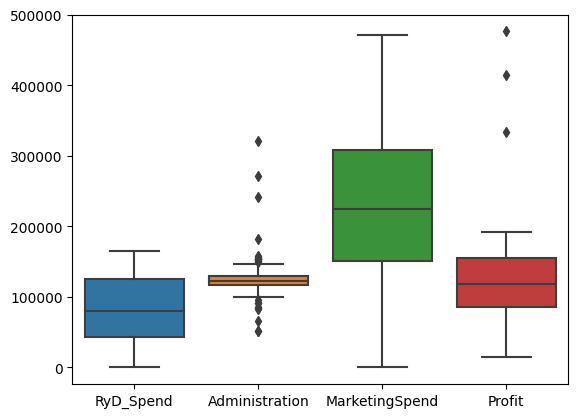

(<Axes: >, None)

In [82]:
sns.boxplot(companies), plt.show()

In [83]:
def graficar_datos_faltantes(df):
    df = df.copy()
    total = df.shape[0]
    nulos = df.isnull().sum()

    df_grafico = pd.DataFrame({'total': total, 'nulos': nulos})

    plt.figure(figsize=(10, 6))
    sns.barplot(y=df_grafico.index, x=df_grafico['total'], color='violet', alpha=0.5)
    sns.barplot(y=df_grafico.index, x=df_grafico['nulos'], color='blue', alpha=0.5)

    plt.xlabel('Cantidad de registros', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.title('Cantidad de datos faltantes por variable', fontsize=16)

    plt.show()

def graficar_elementos_unicos(df):
    n_unicos = df.nunique()

    plt.figure(figsize=(10, 6))
    sns.barplot(x=n_unicos.index, y=n_unicos.values, alpha=0.8)

    plt.ylabel('Cantidad de elementos únicos', fontsize=12)
    plt.xlabel('Variables', fontsize=12)
    plt.title('Cantidad de elementos únicos por variable', fontsize=16)
    plt.xticks(rotation='vertical')

    plt.show()

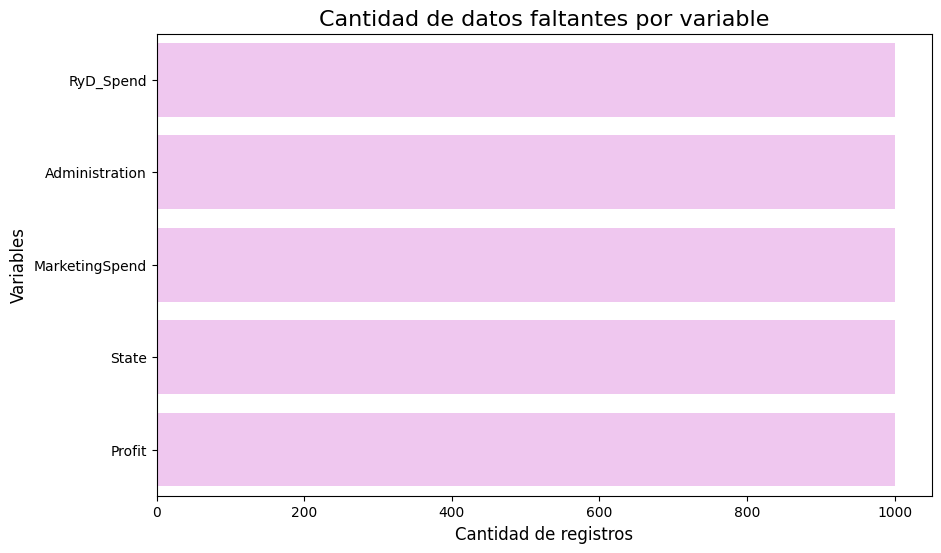

In [84]:
graficar_datos_faltantes(companies)

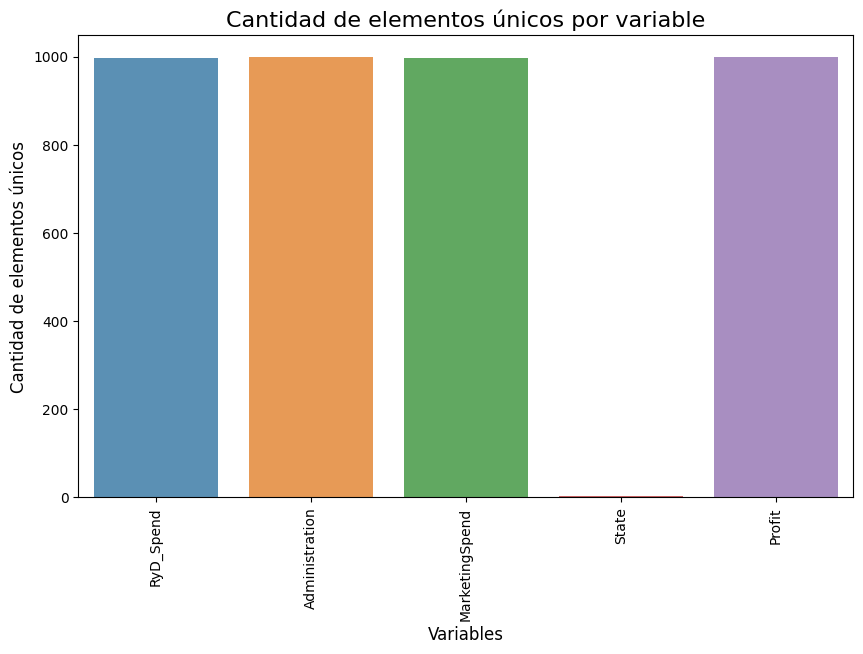

In [85]:
graficar_elementos_unicos(companies)

### Distribuciones por clase

In [86]:
def create_plots(df, explanatory_var, class_var, class_value):
    if class_value != 'Todas':
        df = df[df[class_var] == class_value]

    fig, axs = plt.subplots(3, 1, figsize=(6,8))

    sns.stripplot(x=explanatory_var, y=[""]*len(df), hue=class_var, data=df, jitter=True, ax=axs[0])
    axs[0].set_title('Distribución de ' + explanatory_var + ' con respecto a ' + class_var)
    axs[0].legend('')
    axs[0].set_xlabel("")

    sns.boxplot(y=class_var, x=explanatory_var, data=df, orient='h', ax=axs[1])
    axs[1].legend('')
    axs[1].set_xlabel("")

    sns.kdeplot(data=df, x=explanatory_var, hue=class_var, fill=True, ax=axs[2])
    axs[2].set_xlabel(explanatory_var)
    axs[2].legend('')

    plt.tight_layout()
    plt.show()

explanatory_var_widget = widgets.Dropdown(
    options=[col for col in companies.columns if col not in ['State']],
    description='Explicativa:',
)

class_value_widget = widgets.Dropdown(
    options=['Todas'] + list(companies['State'].unique()),
    description='State:',
)

interact(create_plots, df=widgets.fixed(companies), explanatory_var=explanatory_var_widget, class_var=widgets.fixed('State'), class_value=class_value_widget)


interactive(children=(Dropdown(description='Explicativa:', options=('RyD_Spend', 'Administration', 'MarketingS…

<function __main__.create_plots(df, explanatory_var, class_var, class_value)>

### Distribucion por variable

In [87]:
def create_dist(df, variable):
    # Crear un diccionario de colores
    color_dict = {col: color for col, color in zip(df.columns, sns.color_palette("hsv", len(df.columns)))}

    fig, ax = plt.subplots(figsize=(10, 4))

    # Boxplot
    bp = ax.boxplot(df[variable], patch_artist=True, vert=False)
    bp['boxes'][0].set_facecolor(color_dict[variable])
    bp['boxes'][0].set_alpha(0.7)

    # Violin plot
    vp = ax.violinplot(df[variable], points=500, showmeans=False, showextrema=False, showmedians=False, vert=False)
    vp['bodies'][0].get_paths()[0].vertices[:, 1] = np.clip(vp['bodies'][0].get_paths()[0].vertices[:, 1], 0.8, 1.2)
    vp['bodies'][0].set_color(color_dict[variable])
    vp['bodies'][0].set_alpha(0.25)

    # Scatter plot
    y = np.full(len(df[variable]), 0.75) + np.random.uniform(low=-.05, high=.05, size=len(df[variable]))
    ax.scatter(df[variable], y, s=8, color=color_dict[variable], alpha=0.5)

    # Configurar títulos y etiquetas
    ax.set_title(variable)
    ax.set_yticks([])
    ax.set_xlabel("Value")

    plt.show()

# Crear selector de variable
variable_widget = widgets.Dropdown(
    options=[col for col in companies.columns],
    description='Variable:',
)

# Usar interact para crear la actualizar el grafico en un cambio
interact(create_dist, df=widgets.fixed(companies), variable=variable_widget)


interactive(children=(Dropdown(description='Variable:', options=('RyD_Spend', 'Administration', 'MarketingSpen…

<function __main__.create_dist(df, variable)>

### Valores atipicos

Tenemos atipicos, pero los modelo basados en arboles no se ven afectados por ellos ya que no asumen distirbuciones en los datos.

Aun asi podemos probar un dataframe discretizando el rango de las variables con atipicos a clases, de forma que los valores extremos menos frecuentes tengan menos peso.

In [88]:
def bin_columns(df, cols, n_bins):
    df_binned = df.copy()
    for col in cols:
        df_binned[col] = pd.cut(df_binned[col], bins=n_bins, labels=False)
    return df_binned

companies_binned = bin_columns(companies, ['Profit', 'Administration'], 30)
companies_binned.head()

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,165349.20,9,471784.10,New York,11
1,162597.70,11,443898.53,California,11
2,153441.51,5,407934.54,Florida,11
3,144372.41,7,383199.62,New York,10
4,142107.34,4,366168.42,Florida,9


### Codificacion

In [89]:
def encode_frequency(df, cols):
    for col in cols:
        freq = df[col].value_counts(normalize=True)
        df[col] = df[col].map(freq)
    return df

companies_encoded = encode_frequency(companies, ['State']) # probe con el binned tambien pero el modelo del ej2 no rinde bien

### Correlaciones

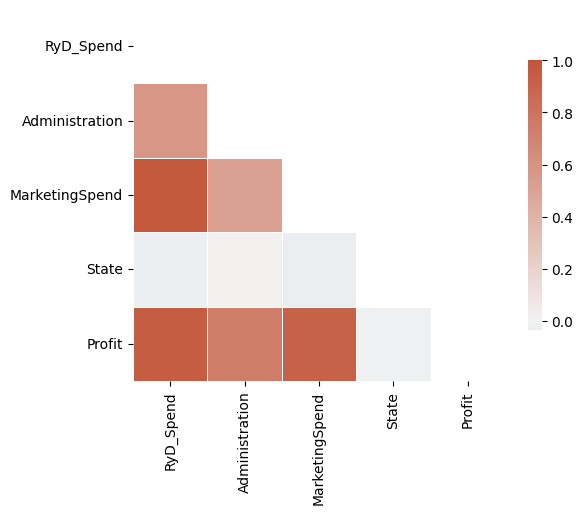

In [90]:
def grafico_correlacion(df, columnas):
    df_copy = df.copy()  # Hacer una copia del dataframe

    for columna in columnas:
        # Hacer un encoding de frecuencia para la variable categórica
        encoding = df_copy.groupby(columna).size()
        encoding = encoding / len(df_copy)
        df_copy[columna] = df_copy[columna].map(encoding)

    # Calcular la matriz de correlación
    corr = df_copy.corr()

    # Crear una máscara para el triángulo superior
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Configurar la figura de matplotlib
    fig, ax = plt.subplots(figsize=(6, 7))

    # Generar un mapa de colores divergentes personalizado
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Dibujar el mapa de calor con la máscara y la relación de aspecto correcta
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    # Mostrar el gráfico
    plt.show()

grafico_correlacion(companies, ['State'])


### Estandarizacion

In [91]:
def estandarize(df):
  data = df.copy()
  numeric_cols = data.select_dtypes(include=[np.number]).columns
  scaler = StandardScaler()

  data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
  return data, scaler

def normalize(df):
  data = df.copy()
  numeric_cols = data.select_dtypes(include=[np.number]).columns
  scaler = MinMaxScaler()

  data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
  return data, scaler

def robustize(df):
  data = df.copy()
  numeric_cols = data.select_dtypes(include=[np.number]).columns
  scaler = RobustScaler()

  data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
  return data, scaler

In [92]:
# Crear un diccionario de funciones de estandarización
standardize_dict = {
    'Estandar': estandarize,
    'MinMax': normalize,
    'Robust': robustize
}

def show_distributions(df, method):
    df_standardized, _ = standardize_dict[method](df)
    plt.figure(figsize=(8, 4))
    sns.boxplot(df_standardized)
    plt.xticks(rotation=90)
    plt.show()

# Crear selector de método de estandarización
method_widget = widgets.Dropdown(
    options=[method for method in standardize_dict.keys()],
    description='Método:',
)

# Usar interact para crear la actualizar el gráfico en un cambio
interact(show_distributions, df=widgets.fixed(companies_encoded), method=method_widget)


interactive(children=(Dropdown(description='Método:', options=('Estandar', 'MinMax', 'Robust'), value='Estanda…

<function __main__.show_distributions(df, method)>

In [93]:
df_standar, standar_scaler = estandarize(companies_encoded)
df_standar.head(2)

,RyD_Spend,Administration,MarketingSpend,State,Profit
0,1.799023,1.105197,2.682968,0.047231,1.696301
1,1.739869,2.253692,2.378316,1.161177,1.685343


## **Segundo ejercicio**

---

Realizar la estimación del atributo Profit utilizando árboles de decisión (Regresión)
analizando los parámetros máximo profundidad, número mínimo de observaciones,
número mínimo de observaciones por separación y criterio de separación. Graficar el
árbol obtenido en el proceso de entrenamiento y mostrar los resultados sobre dos
conjuntos de test (Error Absoluto Medio, Error Cuadrático Medio y Raíz del Error
Cuadrático Medio)

---

### Regresion de arboles de decision

IntSlider(value=1, description='Max Depth:', max=20, min=1)

IntSlider(value=2, description='Min Split:', max=50, min=2)

IntSlider(value=1, description='Min Leaf:', max=50, min=1)

Dropdown(description='Criterion:', options=('squared_error', 'friedman_mse', 'absolute_error'), value='squared…

Button(description='Estimar Profit', style=ButtonStyle())

Output()

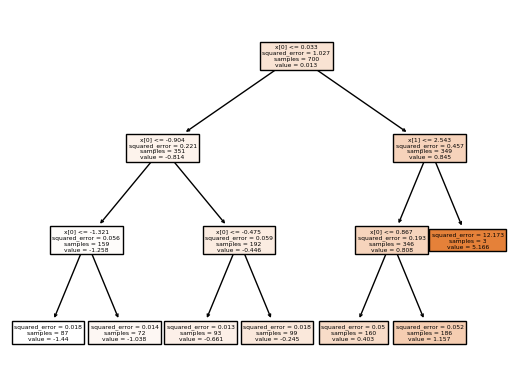

In [119]:

# Crear los widgets para los parámetros
max_depth_widget = widgets.IntSlider(min=1, max=20, step=1, description='Max Depth:')
min_samples_split_widget = widgets.IntSlider(min=2, max=50, step=1, description='Min Split:')
min_samples_leaf_widget = widgets.IntSlider(min=1, max=50, step=1, description='Min Leaf:')
criterion_widget = widgets.Dropdown(options=['squared_error', 'friedman_mse', 'absolute_error'], description='Criterion:')

# Crear el botón para realizar la estimación
button = widgets.Button(description="Estimar Profit")
# Crear un contenedor de salida para mostrar los resultados
out = widgets.Output()

# Función que se ejecuta cuando se presiona el botón
def on_button_clicked(b):
    # Limpiar la salida del contenedor de salida
    out.clear_output()

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_temp, y_train, y_temp = train_test_split(df_standar.drop('Profit', axis=1), df_standar['Profit'], test_size=0.3, random_state=42)
    X_test1, X_test2, y_test1, y_test2 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Crear y entrenar el modelo
    model = DecisionTreeRegressor(max_depth=max_depth_widget.value,
                                  min_samples_split=min_samples_split_widget.value,
                                  min_samples_leaf=min_samples_leaf_widget.value,
                                  criterion=criterion_widget.value)
    model.fit(X_train, y_train)

    # Realizar las predicciones y calcular los errores
    predictions1 = model.predict(X_test1)
    mae1 = mean_absolute_error(y_test1, predictions1)
    mse1 = mean_squared_error(y_test1, predictions1)
    rmse1 = sqrt(mse1)
    r21 = r2_score(y_test1, predictions1)

    predictions2 = model.predict(X_test2)
    mae2 = mean_absolute_error(y_test2, predictions2)
    mse2 = mean_squared_error(y_test2, predictions2)
    rmse2 = sqrt(mse2)
    r22 = r2_score(y_test2, predictions2)

    # Crear un DataFrame para mostrar los resultados
    results = pd.DataFrame({
        'Conjunto de prueba': ['Prueba 1', 'Prueba 2'],
        'Error Absoluto Medio': [mae1, mae2],
        'Error Cuadrático Medio': [mse1, mse2],
        'Raíz del Error Cuadrático Medio': [rmse1, rmse2],
        'R^2': [r21, r22]
    })

    # Mostrar los resultados en el contenedor de salida
    with out:
        display(results)
        plot_tree(model, filled=True)

# Asignar la función al botón
button.on_click(on_button_clicked)

# Mostrar los widgets y el contenedor de salida
display(max_depth_widget, min_samples_split_widget, min_samples_leaf_widget, criterion_widget, button, out)

# 3, 2, 3, squared_error es lo mejor que encontre

## **Tercer ejercicio**

---

Descargar el conjunto de datos, PokemonDB.csv2, para realizar el trabajo práctico.
Analizar los atributos del conjunto de datos (distribuciones, valores, outliers, tipos de
datos, etc.)

---

### Informacion basica

In [95]:
cartas.shape

(1190, 8)

In [96]:
cartas.head()

,Name,Type,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Grass,45,49,49,65,65,45
1,Ivysaur,Grass,60,62,63,80,80,60
2,Venusaur,Grass,80,82,83,100,100,80
3,Venusaur,Grass,80,100,123,122,120,80
4,Charmander,Fire,39,52,43,60,50,65


In [97]:
cartas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Name     1190 non-null   object
 1   Type     1190 non-null   object
 2   HP       1190 non-null   int64 
 3   Attack   1190 non-null   int64 
 4   Defense  1190 non-null   int64 
 5   Sp. Atk  1190 non-null   int64 
 6   Sp. Def  1190 non-null   int64 
 7   Speed    1190 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 74.5+ KB


In [98]:
cartas.describe()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,70.852941,80.957983,74.586555,72.756303,72.050420,69.695798
std,26.886443,32.119650,30.718212,32.658636,27.637522,30.204376
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,51.250000,56.000000,51.000000,50.000000,50.000000,45.000000
50%,70.000000,80.000000,70.000000,65.000000,70.000000,67.000000
75%,85.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,255.000000,190.000000,250.000000,194.000000,250.000000,200.000000


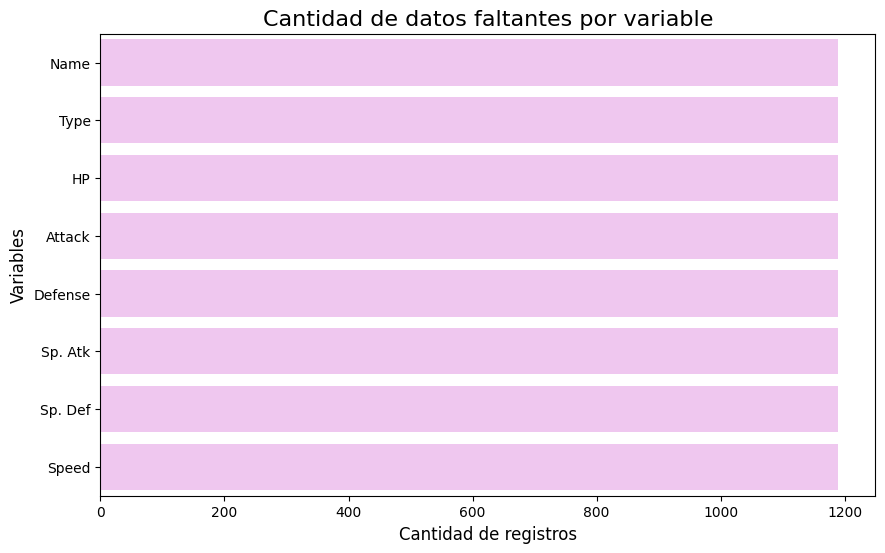

In [99]:
graficar_datos_faltantes(cartas)

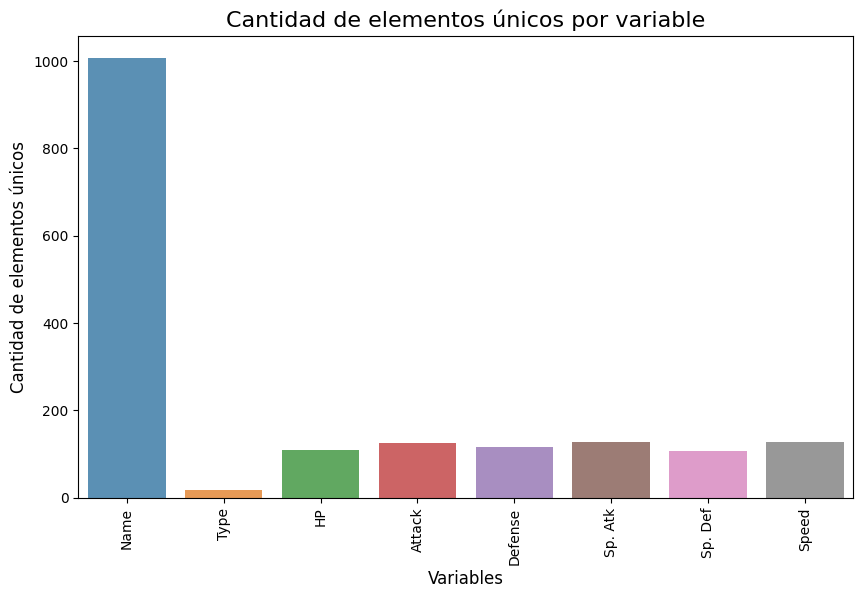

In [100]:
graficar_elementos_unicos(cartas)

### Distribuciones por clase

In [101]:
explanatory_var_widget = widgets.Dropdown(
    options=[col for col in cartas.columns if col not in ['Type', 'Name']],
    description='Explicativa:',
)

class_value_widget = widgets.Dropdown(
    options=['Todas'] + list(cartas['Type'].unique()),
    description='Type:',
)

interact(create_plots, df=widgets.fixed(cartas), explanatory_var=explanatory_var_widget, class_var=widgets.fixed('Type'), class_value=class_value_widget)


interactive(children=(Dropdown(description='Explicativa:', options=('HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp.…

<function __main__.create_plots(df, explanatory_var, class_var, class_value)>

### Distribucion por variable

In [102]:
# Crear selector de variable
variable_widget = widgets.Dropdown(
    options=[col for col in cartas.columns if col not in ['Type', 'Name']],
    description='Variable:',
)

# Usar interact para crear la actualizar el grafico en un cambio
interact(create_dist, df=widgets.fixed(cartas), variable=variable_widget)

interactive(children=(Dropdown(description='Variable:', options=('HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. De…

<function __main__.create_dist(df, variable)>

### Duplicados

In [103]:
# Crear una máscara booleana para las filas donde 'Name' se repite
mask = cartas.duplicated('Name', keep=False)

# Aplicar la máscara al dataframe
cartas[mask]

,Name,Type,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
2,Venusaur,Grass,80,82,83,100,100,80
3,Venusaur,Grass,80,100,123,122,120,80
6,Charizard,Fire,78,84,78,109,85,100
7,Charizard,Fire,78,130,111,130,85,100
8,Charizard,Fire,78,104,78,159,115,100
...,...,...,...,...,...,...,...,...
1143,Palafin,Water,100,160,97,106,87,100
1161,Dudunsparce,Normal,125,100,80,85,75,55
1162,Dudunsparce,Normal,125,100,80,85,75,55
1179,Gimmighoul,Ghost,45,30,70,75,70,10


In [104]:
# Eliminar las filas duplicadas
cartas = cartas.drop_duplicates()
cartas[mask]

<ipython-input-104-e944975ebdef>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cartas[mask]


,Name,Type,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
2,Venusaur,Grass,80,82,83,100,100,80
3,Venusaur,Grass,80,100,123,122,120,80
6,Charizard,Fire,78,84,78,109,85,100
7,Charizard,Fire,78,130,111,130,85,100
8,Charizard,Fire,78,104,78,159,115,100
...,...,...,...,...,...,...,...,...
1142,Palafin,Water,100,70,72,53,62,100
1143,Palafin,Water,100,160,97,106,87,100
1161,Dudunsparce,Normal,125,100,80,85,75,55
1179,Gimmighoul,Ghost,45,30,70,75,70,10


### Valores atipicos

ver como tartarlos

<Axes: >

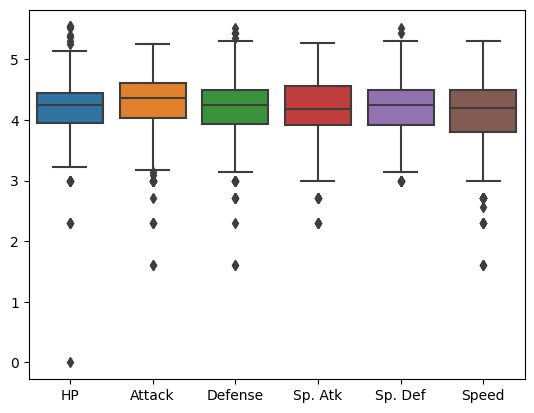

In [105]:
cartas_log = cartas.copy()
for col in cartas_log.select_dtypes(include=[np.number]).columns:
    cartas_log[col] = np.log(cartas_log[col])

sns.boxplot(cartas_log)

### Correlacion

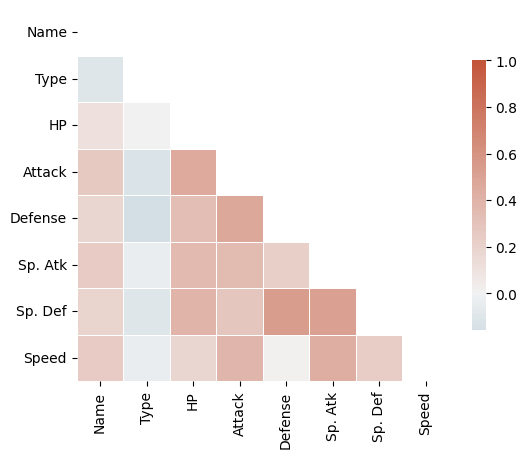

In [108]:
grafico_correlacion(cartas, ['Type', 'Name'])

### Codificacion

Como a los arboles no les interesa una codificacion de clases como a los modelo de regresion, podemos codificar con Labelencoder ya que no interpreta a un tipo como mayor que otro.

In [149]:
cartas_encoded = cartas.copy()

# Crear el LabelEncoder
le = LabelEncoder()

# Aplicar el LabelEncoder a las columnas deseadas
cartas_encoded['Type'] = le.fit_transform(cartas_encoded['Type'])
cartas_encoded['Name'] = le.fit_transform(cartas_encoded['Name'])

## **Cuarto ejercicio**

---

Realizar la estimación del atributo Type utilizando árboles de decisión (Clasificación)
analizando los parámetros máximo profundidad, número mínimo de observaciones,
número mínimo de observaciones por separación y criterio de separación. Graficar el
árbol obtenido en el proceso de entrenamiento y mostrar los resultados sobre dos
conjuntos de test (Precisión, Exhaustividad y Exactitud).

---

### Section

IntSlider(value=1, description='Max Depth:', max=20, min=1)

IntSlider(value=2, description='Min Split:', max=50, min=2)

IntSlider(value=1, description='Min Leaf:', max=50, min=1)

Dropdown(description='Criterion:', options=('gini', 'entropy'), value='gini')

Button(description='Estimar Type', style=ButtonStyle())

Output()

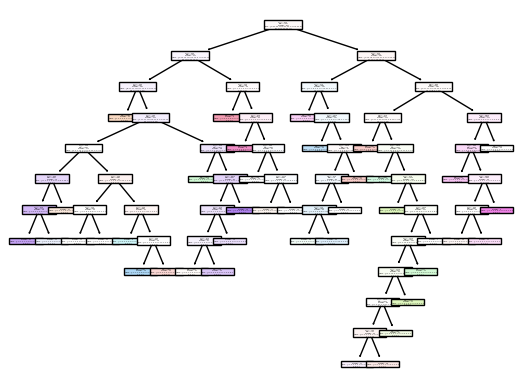

In [150]:
# Crear los widgets para los parámetros
max_depth_widget = widgets.IntSlider(min=1, max=20, step=1, description='Max Depth:')
min_samples_split_widget = widgets.IntSlider(min=2, max=50, step=1, description='Min Split:')
min_samples_leaf_widget = widgets.IntSlider(min=1, max=50, step=1, description='Min Leaf:')
criterion_widget = widgets.Dropdown(options=['gini', 'entropy'], description='Criterion:')

# Crear el botón para realizar la estimación
button = widgets.Button(description="Estimar Type")
# Crear un contenedor de salida para mostrar los resultados
out = widgets.Output()

# Función que se ejecuta cuando se presiona el botón
def on_button_clicked(b):
    # Limpiar la salida del contenedor de salida
    out.clear_output()

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_temp, y_train, y_temp = train_test_split(cartas_encoded.drop('Type', axis=1), cartas_encoded['Type'], test_size=0.3, random_state=42)
    X_test1, X_test2, y_test1, y_test2 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Crear y entrenar el modelo
    model = DecisionTreeClassifier(max_depth=max_depth_widget.value,
                                   min_samples_split=min_samples_split_widget.value,
                                   min_samples_leaf=min_samples_leaf_widget.value,
                                   criterion=criterion_widget.value)
    model.fit(X_train, y_train)

    # Realizar las predicciones y calcular los errores
    predictions1 = model.predict(X_test1)
    probabilities1 = model.predict_proba(X_test1)
    precision1 = precision_score(y_test1, predictions1, average='macro', zero_division=0)
    recall1 = recall_score(y_test1, predictions1, average='macro')
    accuracy1 = accuracy_score(y_test1, predictions1)
    auc1 = roc_auc_score(y_test1, probabilities1, multi_class='ovr')

    predictions2 = model.predict(X_test2)
    probabilities2 = model.predict_proba(X_test2)
    precision2 = precision_score(y_test2, predictions2, average='macro', zero_division=0)
    recall2 = recall_score(y_test2, predictions2, average='macro')
    accuracy2 = accuracy_score(y_test2, predictions2)
    auc2 = roc_auc_score(y_test2, probabilities2, multi_class='ovr')

    # Crear un DataFrame para mostrar los resultados
    results = pd.DataFrame({
        'Conjunto de prueba': ['Prueba 1', 'Prueba 2'],
        'Precisión': [precision1, precision2],
        'Exhaustividad': [recall1, recall2],
        'Exactitud': [accuracy1, accuracy2],
        'AUC': [auc1, auc2]
    })

    # Mostrar los resultados en el contenedor de salida
    with out:
        display(results)
        plot_tree(model, filled=True)

# Asignar la función al botón
button.on_click(on_button_clicked)

# Mostrar los widgets y el contenedor de salida
display(max_depth_widget, min_samples_split_widget, min_samples_leaf_widget, criterion_widget, button, out)

# 18, 42, 6, gini es lo mejor que encontre


## **Quinto ejercicio**

---

Realizar la estimación del atributo Type utilizando Bayes Ingenuo. Aquí deberá
considerar un criterio de división de los atributos para discretizarlos. Mostrar los
resultados sobre dos conjuntos de test (Precisión, Exhaustividad y Exactitud).

---

### Section

### Section

## **Sexto ejercicio**

---

Realizar la estimación del atributo Type utilizando k-NN analizando los parámetros
cantidad de vecinos, métrica y valor de p. Mostrar los resultados sobre un conjunto de
test (Precisión, Exhaustividad y Exactitud)

---

### Section

### Section

# ***Conclusiones***